In [1]:
import pandas as pd

In [2]:
df = pd.read_json('train.json')

In [3]:
df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [4]:
total = df.groupby('cuisine').count()['id']
total

cuisine
brazilian        467
british          804
cajun_creole    1546
chinese         2673
filipino         755
french          2646
greek           1175
indian          3003
irish            667
italian         7838
jamaican         526
japanese        1423
korean           830
mexican         6438
moroccan         821
russian          489
southern_us     4320
spanish          989
thai            1539
vietnamese       825
Name: id, dtype: int64

In [5]:
total.sort_values(inplace=False)

cuisine
brazilian        467
russian          489
jamaican         526
irish            667
filipino         755
british          804
moroccan         821
vietnamese       825
korean           830
spanish          989
greek           1175
japanese        1423
thai            1539
cajun_creole    1546
french          2646
chinese         2673
indian          3003
southern_us     4320
mexican         6438
italian         7838
Name: id, dtype: int64

In [6]:
df.loc[0]['ingredients']

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

In [7]:
df['ingredient_string'] = pd.Series([";".join(ingr) for ingr in df['ingredients']])

In [8]:
df.loc[0]['ingredient_string']

'romaine lettuce;black olives;grape tomatoes;garlic;pepper;purple onion;seasoning;garbanzo beans;feta cheese crumbles'

In [9]:
(df[df['ingredient_string'].str.contains('soy')].groupby('cuisine').count()['id'] / total).sort_values(inplace=False)

cuisine
french          0.002646
italian         0.003445
spanish         0.004044
moroccan        0.004872
greek           0.005106
russian         0.006135
british         0.006219
brazilian       0.006424
southern_us     0.008102
cajun_creole    0.009056
mexican         0.009941
irish           0.010495
indian          0.011988
jamaican        0.155894
vietnamese      0.281212
thai            0.319038
filipino        0.378808
japanese        0.533380
korean          0.661446
chinese         0.760569
Name: id, dtype: float64

In [10]:
df['ingredient_string']

0        romaine lettuce;black olives;grape tomatoes;ga...
1        plain flour;ground pepper;salt;tomatoes;ground...
2        eggs;pepper;salt;mayonaise;cooking oil;green c...
3                           water;vegetable oil;wheat;salt
4        black pepper;shallots;cornflour;cayenne pepper...
5        plain flour;sugar;butter;eggs;fresh ginger roo...
6        olive oil;salt;medium shrimp;pepper;garlic;cho...
7        sugar;pistachio nuts;white almond bark;flour;v...
8        olive oil;purple onion;fresh pineapple;pork;po...
9        chopped tomatoes;fresh basil;garlic;extra-virg...
10       pimentos;sweet pepper;dried oregano;olive oil;...
11       low sodium soy sauce;fresh ginger;dry mustard;...
12       Italian parsley leaves;walnuts;hot red pepper ...
13       ground cinnamon;fresh cilantro;chili powder;gr...
14       fresh parmesan cheese;butter;all-purpose flour...
15       tumeric;vegetable stock;tomatoes;garam masala;...
16       greek yogurt;lemon curd;confectioners sugar;ra.

# La matrice des poids 

In [11]:
df_train = pd.read_json('train.json')
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(token_pattern=r"(?u)\b\w[\w\s]+\b")
X = cv.fit_transform([";".join(_) for _ in df_train.ingredients])
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
y = enc.fit_transform(df_train.cuisine)
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

([<matplotlib.axis.XTick at 0x11038a048>,
 <a list of 20 Text xticklabel objects>)

/Users/kappamaki/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


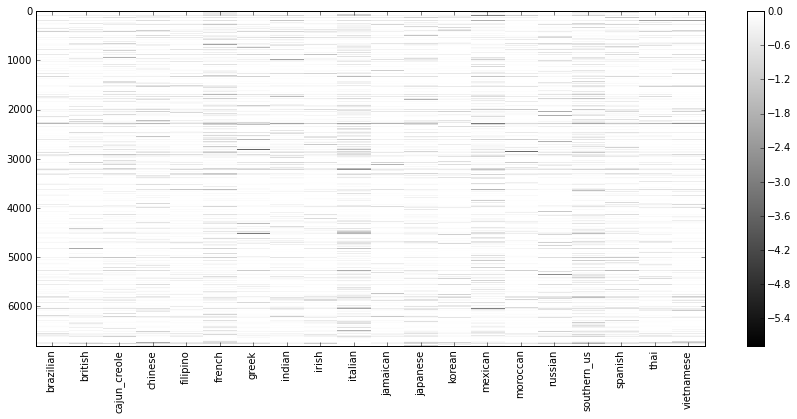

In [13]:
plt.figure(figsize=(15, 6))
plt.imshow(-np.abs(logistic.coef_.T), aspect='auto', cmap='gray', interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(20), enc.inverse_transform(np.arange(20)), rotation='90')

In [14]:
logistic.coef_.shape

(20, 6815)

Et si on regardait ligne par ligne (ingrédient donné) ?

In [15]:
from IPython.html.widgets import interact

:0: FutureWarning: IPython widgets are experimental and may change in the future.


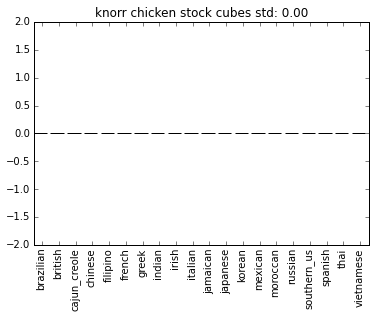

In [16]:
@interact
def plot_ingredient_histogram(ing=(0, logistic.coef_.shape[1] - 1)):
    hist = logistic.coef_[:, ing]
    plt.title(cv.get_feature_names()[ing] + " std: {:.2f}".format(np.std(hist)))
    plt.bar(np.arange(20), hist)
    plt.xticks(np.arange(20) + 0.5, enc.inverse_transform(np.arange(20)), rotation='90')
    plt.ylim(-2, 2)

In [17]:
cv.get_feature_names().index('butter')

775

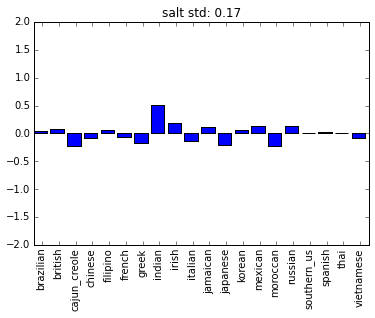

In [18]:
plot_ingredient_histogram(5311)

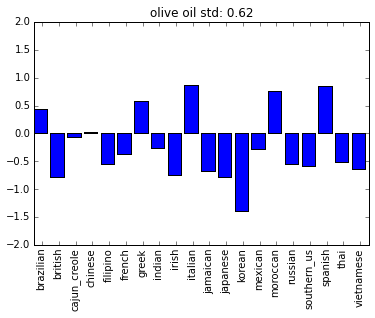

In [19]:
plot_ingredient_histogram(4254)

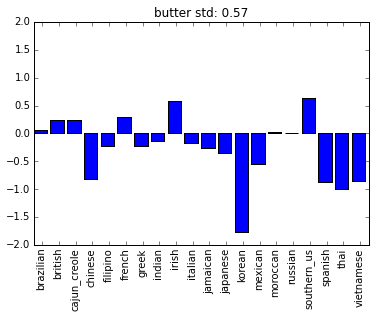

In [20]:
plot_ingredient_histogram(775)

# Mauvaise classification 

In [21]:
y_test_predict = logistic.predict(X_test)

In [22]:
miss = np.where(y_test_predict != y_test)[0]
miss

array([   0,    5,    7, ..., 7949, 7950, 7952])

In [23]:
row = X_test[miss[0], :]
row

<1x6815 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [24]:
np.nonzero(row)[1]

array([5663, 4609, 5508, 6530], dtype=int32)

In [25]:
[cv.get_feature_names()[i] for i in np.nonzero(row)[1]]

['smoked pork neck bones', 'pinto beans', 'shortening', 'water']

In [26]:
logistic.predict_proba(row).shape

(1, 20)

In [27]:
miss.shape

(1777,)

rice powder;rock sugar;on shrimp;shell;lard;egg whites;granulated sugar;ground black pepper;garlic


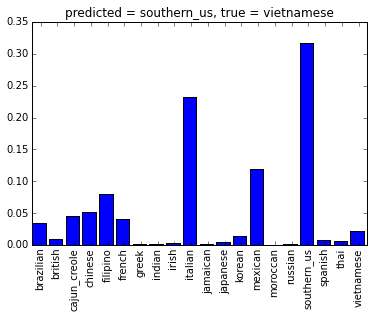

In [28]:
@interact
def plot_miss(idx=(0, miss.size - 1)):
    row = X_test[miss[idx], :] 
    ingr = [cv.get_feature_names()[i] for i in np.nonzero(row)[1]]
    print(";".join(ingr))
    plt.bar(np.arange(20), logistic.predict_proba(row).ravel())
    plt.xticks(np.arange(20) + 0.5, enc.inverse_transform(np.arange(20)), rotation='90');
    plt.title("predicted = {}, true = {}".format(enc.inverse_transform(y_test_predict[miss[idx]]), 
                                                 enc.inverse_transform(y_test[miss[idx]])))

On compte les cas où il y a interversion des deux premiers.

In [29]:
count = 0
mixed_up_top_2 = []
for idx in miss:
    row = X_test[idx, :] 
    proba = [(p, cuisine) for p, cuisine in zip(logistic.predict_proba(row)[0, :], enc.classes_)]
    proba.sort(key=lambda s: s[0], reverse=True)
    true_label = y_test[idx]
    predicted = enc.transform(proba[0][1])
    second_predicted = enc.transform(proba[1][1])
    if second_predicted == true_label:
        count += 1
        mixed_up_top_2.append(idx)

In [30]:
len(mixed_up_top_2)

854

In [31]:
len(miss)

1777

On explore graphiquement les cas où il y a interversion du top 2:

seafood stock;bottled clam juice;dry vermouth;jumbo shrimp;puff pastry;red potato;heavy whipping cream;dried thyme;leeks;large garlic cloves;andouille sausage;purpose flour;all;butter


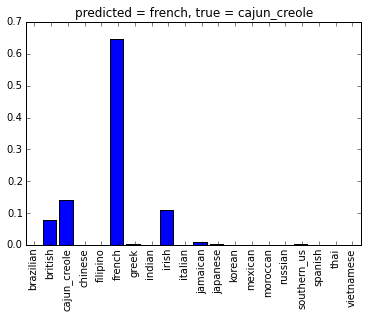

In [32]:
@interact
def plot_miss_mixed_up(idx=(0, len(mixed_up_top_2) - 1)):
    new_idx = miss.tolist().index(mixed_up_top_2[idx])
    plot_miss(new_idx)

Prochaine chose à faire : entraîner des classifieurs pour les duels et voir dans combien de cas ces classifieurs arrivent à gagner le duel!

La documentation pour le one-vs-one est ici : [http://scikit-learn.org/stable/modules/multiclass.html#one-vs-one](http://scikit-learn.org/stable/modules/multiclass.html#one-vs-one).

In [33]:
from sklearn.multiclass import OneVsOneClassifier

In [34]:
ovo = OneVsOneClassifier(LogisticRegression())

In [35]:
ovo.fit(X_train, y_train)

OneVsOneClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

dried red chile peppers;gingerroot;chinese cabbage;green onions;salt;garlic


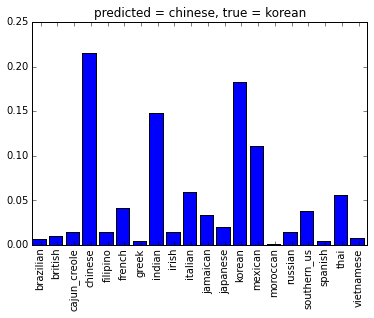

In [36]:
idx = 10
new_idx = miss.tolist().index(mixed_up_top_2[idx])
plot_miss(new_idx)

In [37]:
new_idx

19

In [38]:
ovo.predict(X_test[new_idx, :])

array([3])

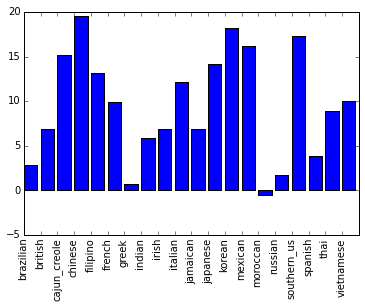

In [39]:
plt.bar(ovo.classes_, ovo.decision_function(X_test[new_idx, :]).T)
plt.xticks(ovo.classes_, enc.inverse_transform(ovo.classes_), rotation=90);

In [40]:
binary_estimators = []
n_classes = ovo.classes_.shape[0]
for i in range(n_classes): 
    for j in range(i + 1, n_classes):
        binary_estimators.append((ovo.classes_[i], ovo.classes_[j]))
print(binary_estimators)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (6, 16), (6, 17), (6, 18), (6, 19), (7, 8), (7, 9), (7, 10), (7, 11),

On peut maintenant revenir aux classes initiales.

seafood stock;bottled clam juice;dry vermouth;jumbo shrimp;puff pastry;red potato;heavy whipping cream;dried thyme;leeks;large garlic cloves;andouille sausage;purpose flour;all;butter


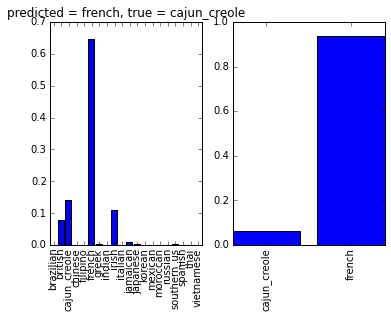

In [41]:
@interact
def two_step_strategy(idx=(0, len(mixed_up_top_2) - 1)):
    # find index in test set
    new_idx = miss.tolist().index(mixed_up_top_2[idx])
    # compute probas
    row = X_test[miss[new_idx], :] 
    proba = [(p, cuisine) for p, cuisine in zip(logistic.predict_proba(row)[0, :], 
                                               enc.transform(enc.classes_))]
    proba.sort(key=lambda s: s[0], reverse=True)
    # extract predictions
    true_label = y_test[new_idx]
    predicted = proba[0][1]
    second_predicted = proba[1][1]
    # showdown
    pair = (min(predicted, second_predicted),
            max(predicted, second_predicted))
    binary_classifier = ovo.estimators_[binary_estimators.index(pair)]
    binary_proba = binary_classifier.predict_proba(row)
    # output
    ingr = [cv.get_feature_names()[i] for i in np.nonzero(row)[1]]
    print(";".join(ingr))
    plt.subplot(121)
    plt.bar(np.arange(20), logistic.predict_proba(row).ravel())
    plt.xticks(np.arange(20) + 0.5, enc.inverse_transform(np.arange(20)), rotation='90');
    plt.title("predicted = {}, true = {}".format(enc.inverse_transform(y_test_predict[miss[new_idx]]), 
                                                 enc.inverse_transform(y_test[miss[new_idx]])))

    plt.subplot(122)
    plt.bar(np.arange(2), binary_proba.ravel())
    plt.xticks(np.arange(2) + 0.4, enc.inverse_transform(np.array(pair)), rotation=90)

In [42]:
predicted

5

In [43]:
second_predicted

16

In [44]:
ovo.estimators_[binary_estimators.index((second_predicted, predicted))].predict(row)

ValueError: (16, 5) is not in list

On peut essayer de quantifier le gain possible.

In [ ]:
class TwoStageClassifier():
    def __init__(self):
        self.logistic = LogisticRegression()
        self.ovo = OneVsOneClassifier(LogisticRegression())
    
    def fit(self, X_train, y_train):
        self.logistic.fit(X_train, y_train)
        self.ovo.fit(X_train, y_train)
        
    def bookkeeping(self):
        binary_estimators = []
        n_classes = self.ovo.classes_.shape[0]
        for i in range(n_classes): 
            for j in range(i + 1, n_classes):
                binary_estimators.append((ovo.classes_[i], ovo.classes_[j]))
        self.binary_estimators = binary_estimators
        
    def predict(self, row, thresh):
        """two stage prediction: logistic first, then binary classifiers between top 2"""
        proba = [(p, cuisine) for p, cuisine in zip(self.logistic.predict_proba(row)[0, :], 
                                               enc.transform(enc.classes_))]
        proba.sort(key=lambda s: s[0], reverse=True)
        # extract predictions

        predicted_label = proba[0][1]
        predicted_label_prob = proba[0][0]
        second_predicted_label = proba[1][1]
        second_predicted_prob = proba[1][0]
        # showdown
        pair = (min(predicted_label, second_predicted_label),
                max(predicted_label, second_predicted_label))
        binary_classifier = self.ovo.estimators_[self.binary_estimators.index(pair)]
        #binary_proba = binary_classifier.predict_proba(row)
        if predicted_label_prob > thresh:
            return np.array(predicted_label)
        else:
            return np.array(pair[binary_classifier.predict(row)])

In [ ]:
tsc = TwoStageClassifier()
tsc.fit(X_train, y_train)
tsc.bookkeeping()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
for thresh in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    y_pred = np.array([])
    for row, true_label in zip(X_test, y_test):
        y_pred = np.append(y_pred, tsc.predict(row, thresh))
    print('========= thresh {} =========='.format(thresh))
    print(classification_report(y_test, y_pred, target_names=enc.classes_))

On peut regarder les vraies probas:

In [ ]:
probs = np.zeros((y_test.size, 2))
for ind, row, true_label in zip(np.arange(X_test.size), X_test, y_test):
    proba = [(p, cuisine) for p, cuisine in zip(tsc.logistic.predict_proba(row)[0, :], 
                                           enc.transform(enc.classes_))]
    proba.sort(key=lambda s: s[0], reverse=True)
    # extract predictions
    predicted = proba[0][0]
    second_predicted = proba[1][0]
    probs[ind, :] = np.array([predicted, second_predicted])

In [ ]:
import pandas as pd

In [ ]:
probs.shape

In [ ]:
df = pd.DataFrame(probs, columns=['first_prob', 'second_prob'])


In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
df.first_prob.hist(bins=50)
plt.subplot(122)
df.second_prob.hist(bins=50)

Et si on regardait plutôt le delta entre les deux probas ?

In [ ]:
plt.figure(figsize=(10, 4))
(df.first_prob - df.second_prob).hist(bins=50)

In [ ]:
6 * 44100 / 300

In [ ]:
6 * 44100 / 100

In [ ]:
44100 / 100

In [ ]:
4 * 44100 / 300

In [ ]:
4 * 44100 / 100

In [ ]:
4 * 44100 / 1601

In [ ]:
4 * 44100 / 2001